# `Predicting Stroke Occurance Using KNN Classification` #
Gael Hernandez Palmer, Asha Octoman, Christina Yang, Julius Brooker

## Introduction ##

#### *Background Information:* #### 
...

#### *Exploratory Question:* ####
...

#### *Dataset:* ####
https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

By: Federico Soriano Palacios

## Preliminary Data Analysis ##

In [ ]:
# loading packages
library(repr)
library(tidyverse)
library(tidymodels)

In [3]:
# loading data
stroke <- read_csv("data/stroke-data.csv")
colnames(stroke)

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)



[1] "id"                "gender"            "age"              
 [4] "hypertension"      "heart_disease"     "ever_married"     
 [7] "work_type"         "Residence_type"    "avg_glucose_level"
[10] "bmi"               "smoking_status"    "stroke"

In [4]:
# cleaning and wrangling
stroke_clean <- stroke %>%
    select(gender, age, hypertension, heart_disease, avg_glucose_level, bmi, smoking_status, stroke) %>%
    mutate(gender = as_factor(gender), 
           bmi = as.numeric(bmi),
           smoking_status = as_factor(smoking_status),
           stroke = as_factor(stroke)) %>%
    filter(gender != "Other") 

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


In [5]:
head(stroke_clean)

gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,228.69,36.6,formerly smoked,1
Female,61,0,0,202.21,NA,never smoked,1
Male,80,0,1,105.92,32.5,never smoked,1
Female,49,0,0,171.23,34.4,smokes,1
Female,79,1,0,174.12,24.0,never smoked,1
Male,81,0,0,186.21,29.0,formerly smoked,1


In [6]:
# Proportions of stroke observations in set
num_obs <- nrow(stroke_clean)
stroke_count <- stroke_clean %>%
  group_by(stroke) %>%
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
stroke_count

`summarise()` ungrouping output (override with `.groups` argument)



stroke,count,percentage
<fct>,<int>,<dbl>
0,4860,95.126248
1,249,4.873752


In [7]:
# data splitting
set.seed(1)

stroke_split <- initial_split(stroke_clean, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

#### Tables and Visualizations ####

In [8]:
# Proportions of stroke observations in training set

stroke_train_proportions <- stroke_train %>%
                      group_by(stroke) %>%
                      summarize(n = n()) %>%
                      mutate(percent = 100*n/nrow(stroke_train))
stroke_train_proportions

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n,percent
<fct>,<int>,<dbl>
0,3655,95.381002
1,177,4.618998


`summarise()` ungrouping output (override with `.groups` argument)



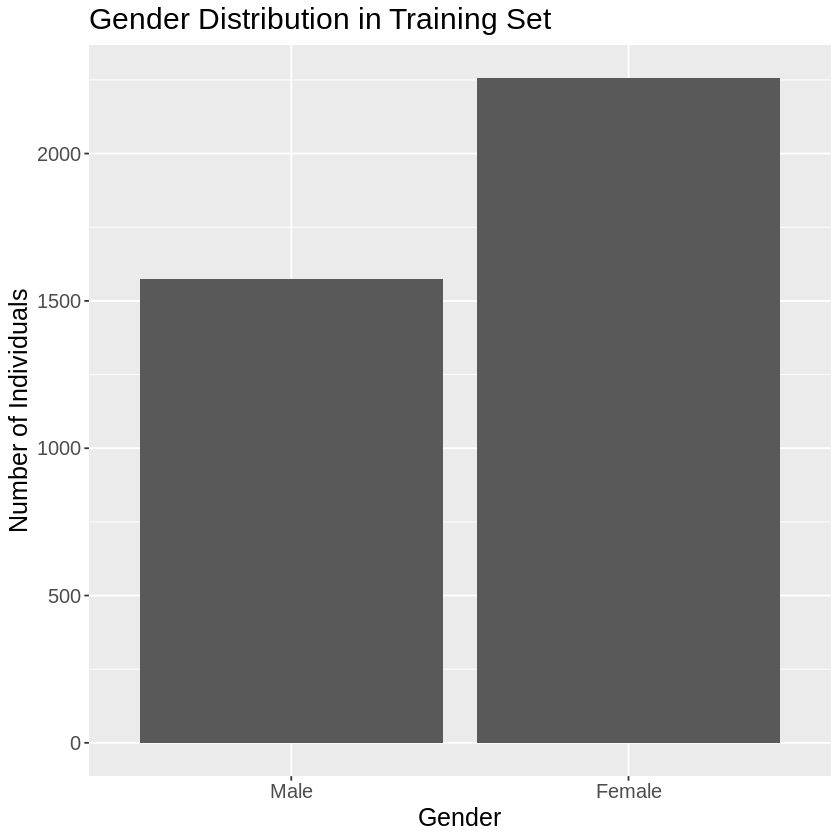

In [9]:
# Gender distribution

stroke_gender <- stroke_train %>%
    group_by(gender) %>%
    summarize(n = n())
    
stroke_gender_plot <- ggplot(stroke_gender, aes(x = gender, y = n)) +
    geom_bar(stat = "identity") +
    xlab("Gender") +
    ylab("Number of Individuals") +
    ggtitle("Gender Distribution in Training Set") +
    theme(text = element_text(size = 15))

stroke_gender_plot

In [10]:
# Binary data instances
# 0 indicates no, 1 indicates yes

stroke_hypertension <- stroke_train %>%
    group_by(hypertension) %>%
    summarize(n = n())
stroke_hypertension

stroke_heart_disease <- stroke_train %>%
    group_by(heart_disease) %>%
    summarize(n = n())
stroke_heart_disease



`summarise()` ungrouping output (override with `.groups` argument)



hypertension,n
<dbl>,<int>
0,3460
1,372


`summarise()` ungrouping output (override with `.groups` argument)



heart_disease,n
<dbl>,<int>
0,3638
1,194


In [11]:
# Numeric predictor variable means 

stroke_var_means <- stroke_train %>%
    summarize(mean_age = mean(age),
              mean_average_glucose_level = mean(avg_glucose_level), 
              mean_bmi = mean(bmi, na.rm = TRUE))

stroke_var_means

mean_age,mean_average_glucose_level,mean_bmi
<dbl>,<dbl>,<dbl>
43.31182,106.8061,28.96737


In [57]:
# Missing data
# Only column which is missing data is bmi (stated in the data description)

stroke_missing <- stroke_train %>%
    pivot_longer(bmi, names_to = "cols", values_to = "vals") %>%
    mutate(missing = is.na(vals)) %>%
    group_by(cols, missing) %>%
    summarise(num_missing = n()) %>%
    filter(missing==T) %>%
    select(-missing) 
stroke_missing

`summarise()` regrouping output by 'cols' (override with `.groups` argument)



cols,num_missing
<chr>,<int>
bmi,158


## Methods ##
...

## Expected Outcomes ##
...

## Significance ##
...